In [1]:

import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import glob
import config
import pandas as pd 

if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    lithdir = datadir.joinpath('lith/sgems/')
    GISdir = datadir.joinpath('GIS')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    lithdir = datadir.joinpath('lith/sgems/')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')

nmgwmdir_empty = datadir.joinpath('nmgwmdir_empty') #<-- removed everything but DIS
nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')

flopy is installed in /home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/flopy
system: linux


In [2]:
#%% Useful functions
def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))


### Load salinity data and success/failure of runs

##### Find data files

In [120]:
# job_id_AEM = 3573022
# job_id_conc = 3573022
# case='SV'

job_id_AEM = 3573239
# job_id_conc = 3573239 

job_id_conc = 3753616 #Jul 7, 2020
case='NM'

## Find AEM data files
ouput_AEM = Path('/scratch/users/ianpg/SWIlarge/work/output/AEM/data/')
aempaths = glob.glob(ouput_AEM.joinpath('{case}*_{job_id}.npy'.format(case=case,job_id=job_id_AEM)).as_posix())
its_AEM = np.array([int(f.split('_')[-2]) for f in aempaths])


output_case = Path('/scratch/users/ianpg/SWIlarge/work/output/{}'.format(case))
f_varlist = Path('../data/PriorModel/varlist.pkl')
varlist = load_obj(f_varlist.parent,'varlist')
ucnpaths = glob.glob(output_case.joinpath('*_{job_id}.UCN'.format(job_id=job_id_conc)).as_posix())
totims = np.array([int([s for s in f.split('_') if 'totim' in s][0].lstrip('totim')) for f in ucnpaths])
its_tds = np.array([int(f.split('_')[0].split('/')[-1].lstrip('conc')) for f in ucnpaths])
failed = totims<14782
its_failed = its_tds[failed]
its_success = its_tds[~failed]
success_AEM = np.array([True if it in its_AEM else False for it in its_tds])

strange = [(it in its_failed) for it in its_AEM]
if np.any(strange):
    print('something weird here... failed seawat run ended up with AEM data?')
#     print('removing these indices...')
#     success_AEM[np.array(strange)] = False

print('Case: {}\nNumber of SEAWAT runs: {} \nFailure rate: {} %'.format(case,len(failed),np.round(100*sum(failed)/len(failed),2)))



something weird here... failed seawat run ended up with AEM data?
Case: NM
Number of SEAWAT runs: 495 
Failure rate: 1.41 %


##### Load the data

In [121]:
#Only load .npy files
ucnpaths = glob.glob(output_case.joinpath('*_{job_id}.npy'.format(job_id=job_id_conc)).as_posix())
totims = np.array([int([s for s in f.split('_') if 'totim' in s][0].lstrip('totim')) for f in ucnpaths])
its_tds = np.array([int(f.split('_')[0].split('/')[-1].lstrip('conc')) for f in ucnpaths])
failed = totims<14782



flag=0
for f,it_tds,it_inAEM in zip(ucnpaths,its_tds,success_AEM):        
    if flag==0:
        matshape_conc = np.load(f).shape
        matsize_conc = np.prod(matshape_conc)
        d_conc = np.zeros((max(its_tds+1),matsize_conc))
        flag=1
    d_conc[it_tds] = np.load(f).flatten()
keep_inds = np.where(d_conc.any(axis=1))[0]
d_conc = d_conc[keep_inds,:]


In [124]:
d_conc_plot = d_conc.copy()
d_conc_plot[d_conc_plot>100]=np.nan

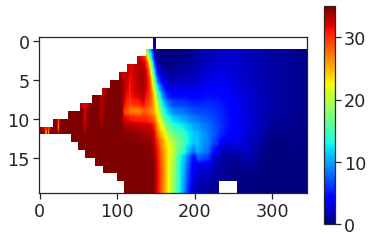

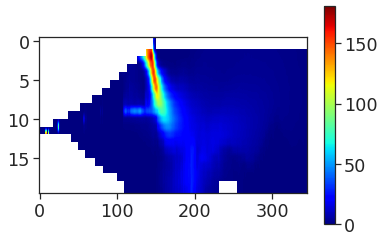

In [125]:
plt.imshow(d_conc_plot.mean(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=35)
plt.gca().set_aspect(10)
plt.colorbar()
plt.show()
plt.imshow(d_conc_plot.var(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet')
plt.gca().set_aspect(10)
plt.colorbar()

In [4]:
print('loading...')
'''
d_conc and d_AEM stored by iteration number so there are some empty indices along first axis corresponding to its_failed
'''
# d_conc = np.zeros((500,20, 19, 345),dtype=np.float)
# d_conc_flat = np.zeros((500,20, 19, 345),dtype=np.float)


# d_AEM = np.zeros((500,2940),dtype=np.float) 
flag=0
for f,it_AEM in zip(aempaths,its_AEM):
    if flag==0:
        matshape_AEM = np.load(f).shape
        matsize_AEM= np.prod(matshape_AEM)
        d_AEM = np.zeros((max(its_tds+1),matsize_AEM),dtype=np.float) 
        flag=1
    d_AEM[it_AEM] = np.load(f,allow_pickle=True)


flag=0
for f,it_tds,it_inAEM in zip(ucnpaths,its_tds,success_AEM):   
    if it_inAEM:
        if flag==0:
            matshape_conc = np.load(f.rstrip('UCN') + 'npy').shape
            matsize_conc = np.prod(matshape_conc)
            d_conc = np.zeros((max(its_tds+1),matsize_conc))
            flag=1
        d_conc[it_tds] = np.load(f.rstrip('UCN') + 'npy').flatten()

        

#Verify that mats have missing rows in same indices
if np.all((np.where(~d_conc.any(axis=1))[0] ==  np.where(~d_AEM.any(axis=1))[0])):
    print('matrices line up!')
else:
    print('Warning: matrices do not line up!')        
        
        
keep_inds = np.where(d_conc.any(axis=1))[0]
d_AEM = -d_AEM[keep_inds,:]
d_conc = d_conc[keep_inds,:]

its_AEM = np.sort(its_AEM)
its_tds = np.sort(its_tds[success_AEM])

loading...
matrices line up!


In [5]:
#Load AEM data
d_obs_AEM = np.load(datadir.joinpath('AEM','dobs_{}.npy'.format(case)))
area_304 = 337.04
invalid_msk= d_obs_AEM==9999./area_304
invalid_msk = np.logical_or(invalid_msk,np.isnan(d_AEM[0,:]))
invalid_inds = np.where(invalid_msk)[0]

#Load AEM times
times_HM_304 = np.load(datadir.joinpath('AEM','times_HM_304.npy'))
times_LM_304 = np.load(datadir.joinpath('AEM','times_LM_304.npy'))



# #Take the log
d_obs_AEM=np.log10(d_obs_AEM)
d_AEM=np.log10(d_AEM)

#Remove invalid data
d_conc[d_conc>100]=0.
# d_AEM[:,invalid_inds]=0.
# d_obs_AEM[invalid_inds]=0.

d_AEM = d_AEM[:,~invalid_msk]
d_obs_AEM = d_obs_AEM[~invalid_msk]
d_obs_stash = d_obs_AEM.copy()

##### Load in SEAWAT model geometry

In [6]:
from  pyproj import Proj

p = Proj("epsg:26910")
xll=595855
yll = 4059438
rotation = -13.5
nmgwmdir_cal_empty = nmgwmdir_cal.parent.joinpath('nmgwmdir_empty')

m_nm= flopy.modflow.Modflow.load('nm_cali.nam',version='mf2k',verbose=False,check=False,model_ws=nmgwmdir_cal_empty.as_posix())
# m = flopy.modflow.Modflow.load(nmgwmdir_uncal.joinpath('C1-12_copy.nam').as_posix(),version='mf2k',verbose=False,check=False,model_ws=outputdir.joinpath('C1').as_posix())
m_nm.exe_name = config.mf2000exe
if not m_nm.DIS.lenuni==2:
    m_nm.DIS.delr *= .3048
    m_nm.DIS.delc *= .3048
    m_nm.DIS.top *= .3048
    m_nm.DIS.botm *= .3048
m_nm.DIS.lenuni = 2
m_nm.DIS.itmuni=4
m_nm.DIS.rotation=-13.5
# m_nm.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_nm.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_nm.DIS.proj4_str = p.srs
m_nm.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


In [7]:
##Loading
it=10
model_ws = workdir.joinpath('{}_{}'.format(case,it))

modelname = case
m= flopy.seawat.Seawat.load(modelname + '.nam',exe_name=config.swexe, model_ws=model_ws.as_posix())
rows = np.load(model_ws.joinpath('rows.npy'))
starttime = np.load(model_ws.joinpath('starttime.npy'))
layer_mapping_ind_full = np.load(GISdir.joinpath('layer_mapping_ind_full.npy'))                                 
layer_mapping_ind = layer_mapping_ind_full[:,rows,:]
# m = flopy.seawat.Seawat(modelname, exe_name=config.swexe, model_ws=model_ws.as_posix(),verbose=verbose)
# thinmsk_in_aqt = np.load(model_ws.joinpath('thinmsk_in_aqt.npy'))
# wellmsk_in_aqt = np.load(model_ws.joinpath('wellmsk_in_aqt.npy'))
topo_grid = np.load(GISdir.joinpath('topo_grid.npy'))
topo_grid_fine = np.loadtxt(GISdir.joinpath('Topography_fine','TopographyMesh_vertices.csv'),skiprows=1,delimiter=',')

if len(f_varlist.name.split('.'))>1:
    nam = f_varlist.name.split('.')[0]
else:
    nam = f_varlist.name
varlist = load_obj(f_varlist.parent,nam)


m_empty = flopy.modflow.Modflow('m_empty', model_ws=model_ws.joinpath('m_empty').as_posix())
flopy.modflow.ModflowDis(m_empty, m.nlay, m.nrow, m.ncol, nper=m.nper, delr=m.dis.delr,
                               delc=m.dis.delc,
                               laycbd=0, top=m.dis.top,
                               botm=m.dis.botm, perlen=m.dis.perlen, nstp=m.dis.nstp,
                               steady=m.dis.steady,itmuni=m.dis.itmuni,lenuni=m.dis.lenuni,
                               tsmult=m.dis.tsmult)

xll_m,yll_m = m_nm.modelgrid.xvertices[rows[-1]+1,0],m_nm.modelgrid.yvertices[rows[-1]+1,0]





m_empty.DIS.lenuni = 2
m_empty.DIS.itmuni=4
m_empty.DIS.rotation=-13.5
# m_empty.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_empty.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_empty.DIS.proj4_str = p.srs
m_empty.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


##### Load in TDS data

In [8]:
method = 'simple' #'full'


df_TDS = pd.read_excel(datadir.joinpath('WQ','export_TDS_data.xlsx'))
TDSij =[]
for x,y in zip(df_TDS.X_NAD83_UTM10N.values,df_TDS.Y_NAD83_UTM10N.values):
    try:
        TDSij.append(m_empty.modelgrid.intersect(x,y))
    except:
        TDSij.append((np.nan,np.nan))
df_TDS = df_TDS.assign(rowi=np.array(TDSij)[:,0])
df_TDS = df_TDS.assign(colj=np.array(TDSij)[:,1])


#Keep only valid data
tds_data_msk = np.logical_and(~np.logical_or(np.isnan(df_TDS.rowi),np.isnan(df_TDS.colj)),
                              df_TDS.perf_end1_elev>-200)
df_TDS = df_TDS.loc[tds_data_msk,:]
df_TDS = df_TDS.reset_index(drop=True)


#Find layers corresponding to screened interval
z_vert = m_empty.modelgrid.zvertices


top_vert_ind = np.zeros(len(df_TDS),dtype=int)
bot_vert_ind = np.zeros(len(df_TDS),dtype=int)
vert_ind_array = []
inds_raveled = []


for i in range(len(df_TDS)):
    entry = df_TDS.iloc[i]
    #Get indices
    top_vert_ind[i] =  np.argmin(np.abs(entry.perf_start1_elev -  z_vert[:,int(entry.rowi),int(entry.colj)]))
    bot_vert_ind[i] = np.argmin(np.abs(entry.perf_end1_elev -  z_vert[:,int(entry.rowi),int(entry.colj)]))
    if top_vert_ind[i]==bot_vert_ind[i]:
        top_vert_ind[i]-=1
    vert_ind_array.append(np.arange(top_vert_ind[i],bot_vert_ind[i]))
    
    
    inds_raveled.append(np.ravel_multi_index(((vert_ind_array[i]).astype(int),
                                 (np.ones(len(vert_ind_array[i]))*entry.rowi).astype(int),
                                 (np.ones(len(vert_ind_array[i]))*entry.colj).astype(int))
                                ,matshape_conc))
    if len(inds_raveled[i])==0:
        print(i)
    
# vert_ind_array = [np.arange(top,bot) for top,bot in zip(top_vert_ind,bot_vert_ind)]
df_TDS = df_TDS.assign(top_vert_ind=top_vert_ind)
df_TDS = df_TDS.assign(bot_vert_ind=bot_vert_ind)
df_TDS = df_TDS.assign(vert_ind_array=vert_ind_array)
df_TDS = df_TDS.assign(inds_raveled=inds_raveled)


#Get observed TDS
d_tds_obs = np.reshape(df_TDS.loc[:,'conc'].values/1000,(1,-1))


#Get available times
fname = [p for p in ucnpaths if p.split('/')[-1].startswith('conc{}'.format(its_tds[0]))][0]

fname = ucnpaths[0][:-4] + '.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times_sim = ucnobj.get_times()
times_real = float(starttime) + np.array(times_sim)/365





#Collect data from synthetic models
if method=='simple':
    #Collect data from synthetic models
    d_tds = np.zeros((d_conc.shape[0],len(df_TDS)),dtype=np.float)
    for i,c in enumerate(d_conc):
        for j,loc in enumerate(df_TDS.inds_raveled.values):
            d_tds[i,j] = c[loc].mean()
elif method=='pickyear':
    time_rec = 2010.3
    loadtime_ind = np.argmin(np.abs(time_rec-times_real))

    
    d_tds = np.zeros((d_conc.shape[0],len(df_TDS)),dtype=np.float)
    for i,it in enumerate(its_AEM):
        if i%10==0:
            print(i)
        fname = [p for p in ucnpaths if p.split('/')[-1].startswith('conc{}'.format(it))][0]
        ucnobj = flopy.utils.binaryfile.UcnFile(fname)
        load_conc = ucnobj.get_data(totim=times[loadtime_ind]).flatten()
        for j,loc in enumerate(df_TDS.inds_raveled.values):
            d_tds[i,j] = load_conc[loc].mean()
    
elif method=='full':
    loadtime_ind = []
    for i in range(len(df_TDS)):
        entry = df_TDS.date_rec.iloc[i]
        time_rec = entry.year  + entry.month/12
        loadtime_ind.append(np.argmin(np.abs(time_rec-times_real)))

    df_TDS = df_TDS.assign(loadtime_ind=loadtime_ind)
    d_tds = np.zeros((d_conc.shape[0],len(df_TDS)),dtype=np.float)
    for i,it in enumerate(its_AEM):
        if i%10==0:
            print(i)
        fname = [p for p in ucnpaths if p.split('/')[-1].startswith('conc{}'.format(it))][0]
        ucnobj = flopy.utils.binaryfile.UcnFile(fname)
        for tim_ind in df_TDS.loadtime_ind.unique():
            load_conc = ucnobj.get_data(totim=times[tim_ind])
            applytoinds = (tim_ind==df_TDS.loadtime_ind)[tim_ind==df_TDS.loadtime_ind].index.values
            for j in applytoinds:
                d_tds[i,j] = load_conc.flatten()[df_TDS.inds_raveled.values[j]].mean()


In [9]:
import psutil
# you can have the percentage of used RAM
print(psutil.virtual_memory().percent)
# you can calculate percentage of available memory
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)


3.1
96.92176310846835


##### Load TDS data to correspond to the correct simulated time (takes forever!!)

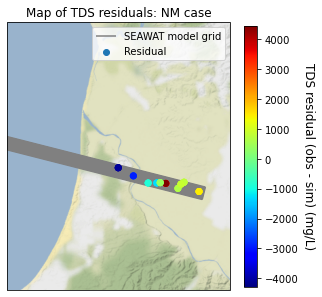

In [10]:
import cartopy
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colorbar
transform = ccrs.UTM(10)

# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize=(5,8))
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

ax.add_image(stamen_terrain, 11)

m_empty.modelgrid.plot(ax=ax,transform=transform,label='SEAWAT model grid')

ax.set_extent([600000., 620000.,4052000., 4075962.], crs=transform)
s = plt.scatter(df_TDS.X_NAD83_UTM10N ,df_TDS.Y_NAD83_UTM10N,
                c=(d_tds_obs-d_tds).mean(axis=0)*1000,
#                 c=df_TDS.perf_start1_elev,
            zorder=10,cmap='jet',transform=transform,label='Residual')
plt.legend()
plt.title('Map of TDS residuals: NM case')


cax,kw = matplotlib.colorbar.make_axes(ax,location='right',pad=0.05,shrink=0.6)
out=fig.colorbar(s,cax=cax,**kw)
label=out.set_label('TDS residual (obs - sim) (mg/L)',size=12,rotation= -90,verticalalignment='bottom')


# plt.savefig(figdir.joinpath('NM_tds_residuals.png'),dpi=300,bbox_inches='tight')

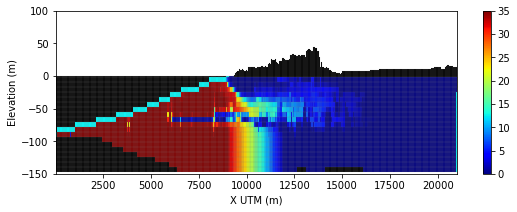

In [11]:
from matplotlib import cm

conc = d_conc[it].reshape(matshape_conc)
conc[conc>100] = np.nan



slicetype='Row'
slicenum= 4

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()
xsect.plot_grid(linewidth=.1)
# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
# csa = xsect.plot_array(kj_lay_red,cmap='tab10')
# csa = xsect.plot_array(np.log(hk),cmap='viridis')
# csa = xsect.plot_array(sconc,cmap='jet',vmin=0,vmax=35)

csa = xsect.plot_array(conc,cmap='jet',vmin=0,vmax=35)

c = plt.colorbar(csa)
# wel = xsect.plot_bc("CHD")
wel = xsect.plot_ibound()
wel = xsect.plot_bc("GHB")

x = np.ravel([np.ones(20)*v for v in df_TDS.X_NAD83_UTM10N.values])
y = np.ravel([np.linspace(end,start,20) for end,start in zip(df_TDS.perf_end1_elev.values,df_TDS.perf_start1_elev.values)])
c = np.ravel([np.ones(20)*v for v in df_TDS.conc.values/1000])
plt.scatter(x,y,c='r',vmin=0,vmax=35,cmap='jet')




# t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-150,100))
plt.xlabel('X UTM (m)')
plt.show()
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('xsection_layers.png'),dpi=300,bbox_inches='tight')

##### Load in thickness of 180/400-FA or salinity of 180-FA

In [12]:
if case=='NM':
    pass
elif case=='SV':
    pass

##### Dim reduction

In [13]:
def reshapeAEM(d,values_to_nan=0.):
    d_reshaped = d.reshape((times_HM_304.size+times_LM_304.size, 83), order='F')
    d_reshaped[d_reshaped==values_to_nan] = np.nan
    return d_reshaped[:times_HM_304.size,:],d_reshaped[times_HM_304.size:,:]


In [14]:
#FROM AUTOBEL

autobeldir = 'source_code/'
if autobeldir not in sys.path:
    sys.path.insert(0,autobeldir)
    
    
import numpy as np
from sklearn.decomposition import PCA

from source_code.scree_plot import scree_plot
from source_code.evd_fast import *
from source_code.RobustMD_flsification import RobustMD_flsification
from source_code.DGSA_light import DGSA_light
from source_code.gsa_pareto_plt import gsa_pareto_plt
from source_code.rgrplt_all_dh import rgrplt_all_dh 
from source_code.cca_and_ccaplt import cca_d_h
from source_code.cca_and_ccaplt import cca_plt
from source_code.gaussianregression_c_dd_star import *
from source_code.post_est_rtn_val import post_est_rtn_val
from source_code.post_est_rtn_val import post_est_clsplt
from source_code.plt_pos_pri_comp import plt_pos_pri_comp


from source_code.combine_mc_samples import *
from source_code.signed_distance_functions import *
from source_code.giip_cal import *

from source_code.gd_wellog_data import gd_wellog_data
from source_code.falsifications import fals_1Dplt, fals_2Dplt
from source_code.outlier_detection import outlier_2d
from source_code.plt_MC_models_smpls import m_ensampl_plt
from source_code.plt_MC_models_smpls import mc_samples_plot
from source_code.qc_reslts_plt import m_ensampl_plt


'''
# model_names: names of the input models, type - list
model_names =['thickness']
# Define model type: 1 - Continous; 2 - Categorical
model_types = [1]
# Define model dimensions in x, y, z directions. 
x_dim, y_dim, z_dim = 200, 100, 1
# Define model horizontal resolution
grid_h_resolution = 250*250
# Provide directory of the prior models
pri_m_samples_dir = 'input/prior_samples/'
# Provide sample size of the prior models
samples_size = 250
# Provide directory of the global parameters
mgl = 'input/thickness_mgl.txt'
# Provide directory of the data observation
dobs_file = 'input/thickness_obs'
'''

"\n# model_names: names of the input models, type - list\nmodel_names =['thickness']\n# Define model type: 1 - Continous; 2 - Categorical\nmodel_types = [1]\n# Define model dimensions in x, y, z directions. \nx_dim, y_dim, z_dim = 200, 100, 1\n# Define model horizontal resolution\ngrid_h_resolution = 250*250\n# Provide directory of the prior models\npri_m_samples_dir = 'input/prior_samples/'\n# Provide sample size of the prior models\nsamples_size = 250\n# Provide directory of the global parameters\nmgl = 'input/thickness_mgl.txt'\n# Provide directory of the data observation\ndobs_file = 'input/thickness_obs'\n"

In [15]:
def eigen_imgs_local(eigen_vecs, eig_nums,matshape,slicenum=10):
    '''
    This is the function to plot the eigen_images
    arg:
        eigen_vecs: the ndarray of the eigen vectors
        eig_nums: 1d arrary defines which pc numbers to plot
        i_dim, j_dim: the i and j dimension of the grid model        
    '''
    plot_num = len(eig_nums)
    fig_row = int((plot_num+3)/4)
    fig=plt.figure(figsize=(15, fig_row*3))
    
    count = 1
    for i in eig_nums:
        plot=fig.add_subplot(fig_row, 4, count)
        count = count+1
        plt.imshow(eigen_vecs[:,i].reshape(matshape)[:,slicenum,:], cmap='jet')  
        plt.gca().set_aspect(7)
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)
        plt.title('model eigen_img (PC' + str(i) +')', fontsize = 14)
    plt.subplots_adjust(top=0.55, bottom=0.08, left=0.10, right=0.95, hspace=0.15,
                    wspace=0.35)
    
    #t = (" ")
    #plt.figure(figsize=(3, 0.1))
    #plt.text(0, 0, t, style='normal', ha='center', fontsize=16, weight = 'bold')
    #plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
    #plt.show()
    return

  
3. Dimension reduction of model and data
2020-07-09 12:32:12:511936
2020-07-09 12:32:26:126489
QC of the model eigen images


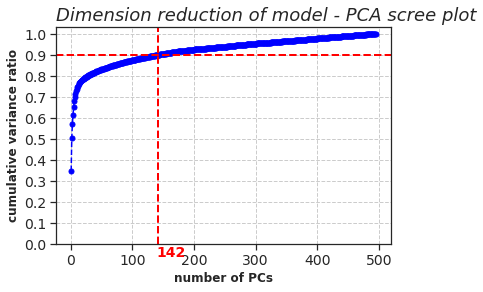

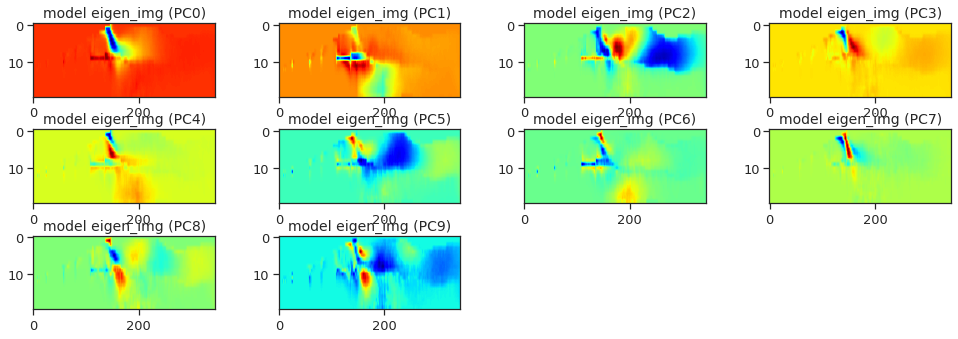

In [48]:
print("  ")
print("3. Dimension reduction of model and data")
'''m_pcnumsc: the number of model PCs to preserve in dimension reduction'''

model_name = 'test_SV_manual'

m_pcnums = []
m_pri = d_conc.copy()

m_pcnum =scree_plot(m_pri, 'model', 90, 'plot')
m_pcnums.append(m_pcnum)
m_mean_pri = m_pri.mean(axis=0)
m_eigvec_pri = evd_fast(m_pri, len(m_pri))
m_pcscr_pri=(m_pri-m_mean_pri).dot(m_eigvec_pri)

output_model = outputdir.joinpath('BEL',case,'model')
output_data = outputdir.joinpath('BEL',case,'data')

if not output_model.exists():
    output_model.mkdir(parents=True)
if not output_data.exists():
    output_data.mkdir(parents=True)



    
np.save(output_model.joinpath('{}_mean_pri.npy'.format(model_name)), m_mean_pri)
np.save(output_model.joinpath('{}_eigvec_pri.npy'.format(model_name)), m_eigvec_pri)
np.save(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)), m_pcscr_pri)

print("QC of the model eigen images")
eigen_imgs_local(m_eigvec_pri, np.arange(10), matshape_conc)


2020-07-09 12:32:29:120645
2020-07-09 12:32:29:395626


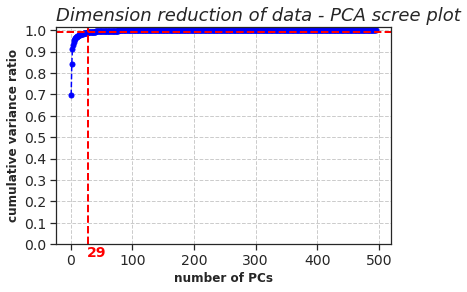

In [49]:
d_pcnum =scree_plot(d_pri, 'data', 99, 'plot')
d_mean_pri = d_pri.mean(axis=0)
d_eigvec_pri = evd_fast(d_pri, len(d_pri))
d_pcscr_pri=(d_pri-d_mean_pri).dot(d_eigvec_pri)
d_pcscr_obs=(d_obs-d_mean_pri).dot(d_eigvec_pri)




np.save(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)), d_pcscr_pri)
np.save(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)), d_pcscr_obs)
np.save(output_data.joinpath('{}_dpca_eigenvec.npy'.format(model_name)), d_eigvec_pri)


  
4. Prior falsification
Robust Mahalanobis Distance of d_obs =  22.143
99th Quantile of Robust Mahalanobis Distance is 22.415
*******************************
>> "test_SV_manual" Prior CANNOT be falsified!
*******************************


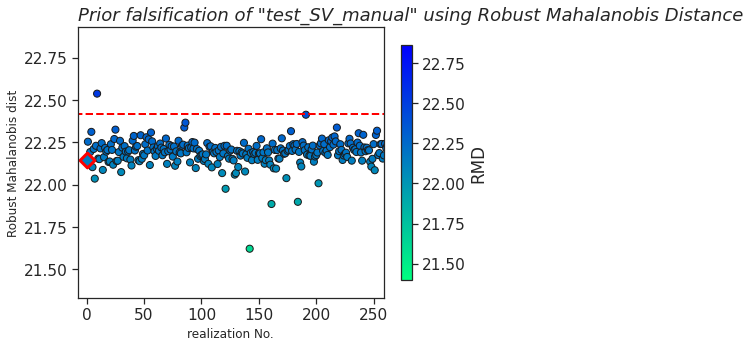

In [50]:
print("  ")
print("4. Prior falsification")
d_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))
d_obs = np.load(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)))
RMD_obs, RMD_Qquantile = RobustMD_flsification(d_pri, d_obs, model_name, True, 99)

if RMD_obs >= RMD_Qquantile:
    print("  ")
    print("******************************************************")
    print(' >> "'+model_name+'" Prior is falsified! Please re-design your prior <<')
    print("******************************************************")
else:
    print("*******************************")
    print('>> "'+model_name+'" Prior CANNOT be falsified!')
    print("*******************************")


In [54]:
np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name))).shape

(494, 494)


 11%|█         | 333/3000 [00:27<01:09, 38.52it/s]

  
5. Global Sensitivity anlaysis-DGSA




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 8/3000 [00:00<00:38, 76.72it/s]

  0%|          | 12/3000 [00:00<00:54, 55.20it/s]

  1%|          | 16/3000 [00:00<01:04, 46.12it/s]

  1%|          | 20/3000 [00:00<01:11, 41.40it/s]

  1%|          | 24/3000 [00:00<01:17, 38.64it/s]

  1%|          | 28/3000 [00:00<01:20, 36.91it/s]

  1%|          | 35/3000 [00:00<01:09, 42.54it/s]

  1%|▏         | 40/3000 [00:00<01:15, 39.32it/s]

  1%|▏         | 44/3000 [00:01<01:19, 37.27it/s]

  2%|▏         | 48/3000 [00:01<01:22, 35.98it/s]

  2%|▏         | 52/3000 [00:01<01:23, 35.42it/s]

  2%|▏         | 58/3000 [00:01<01:14, 39.57it/s]

  2%|▏         | 64/3000 [00:01<01:07, 43.25it/s]

  2%|▏         | 69/3000 [00:01<01:13, 39.69it/s]

  2%|▏         | 74/3000 [00:01<01:17, 37.71it/s]

  3%|▎         | 78/3000 [00:01<01:18, 37.16it/s]

  3%|▎         | 82/3000 [00:02<01:19, 36.77it/s]

  3%|▎         | 87/3000 [00:02<01:15, 38.71it/s]

  3%|▎         | 92/3000 [00:02<01:12, 

 23%|██▎       | 689/3000 [00:17<01:04, 36.02it/s]

 23%|██▎       | 693/3000 [00:17<01:05, 35.14it/s]

 23%|██▎       | 697/3000 [00:17<01:06, 34.49it/s]

 23%|██▎       | 701/3000 [00:17<01:07, 34.18it/s]

 24%|██▎       | 707/3000 [00:17<00:59, 38.54it/s]

 24%|██▎       | 712/3000 [00:18<01:02, 36.77it/s]

 24%|██▍       | 718/3000 [00:18<00:56, 40.71it/s]

 24%|██▍       | 724/3000 [00:18<00:51, 44.18it/s]

 24%|██▍       | 731/3000 [00:18<00:46, 48.37it/s]

 25%|██▍       | 737/3000 [00:18<00:53, 42.66it/s]

 25%|██▍       | 742/3000 [00:18<00:57, 39.41it/s]

 25%|██▍       | 747/3000 [00:18<00:57, 38.97it/s]

 25%|██▌       | 752/3000 [00:19<01:00, 37.08it/s]

 25%|██▌       | 756/3000 [00:19<01:02, 35.81it/s]

 25%|██▌       | 760/3000 [00:19<01:04, 35.00it/s]

 26%|██▌       | 765/3000 [00:19<01:00, 36.80it/s]

 26%|██▌       | 770/3000 [00:19<00:55, 39.84it/s]

 26%|██▌       | 775/3000 [00:19<00:59, 37.59it/s]

 26%|██▌       | 780/3000 [00:19<00:54, 40.51it/s]

 26%|██▌    

 46%|████▌     | 1378/3000 [00:34<00:46, 34.78it/s]

 46%|████▌     | 1382/3000 [00:34<00:47, 34.34it/s]

 46%|████▌     | 1386/3000 [00:34<00:46, 35.08it/s]

 46%|████▋     | 1390/3000 [00:35<00:44, 36.03it/s]

 46%|████▋     | 1394/3000 [00:35<00:43, 36.70it/s]

 47%|████▋     | 1398/3000 [00:35<00:43, 37.20it/s]

 47%|████▋     | 1403/3000 [00:35<00:40, 39.75it/s]

 47%|████▋     | 1410/3000 [00:35<00:35, 44.75it/s]

 47%|████▋     | 1417/3000 [00:35<00:32, 49.11it/s]

 47%|████▋     | 1424/3000 [00:35<00:29, 52.70it/s]

 48%|████▊     | 1431/3000 [00:35<00:28, 55.55it/s]

 48%|████▊     | 1438/3000 [00:35<00:26, 58.22it/s]

 48%|████▊     | 1445/3000 [00:36<00:25, 60.42it/s]

 48%|████▊     | 1452/3000 [00:36<00:31, 48.70it/s]

 49%|████▊     | 1458/3000 [00:36<00:35, 43.40it/s]

 49%|████▉     | 1463/3000 [00:36<00:34, 44.26it/s]

 49%|████▉     | 1468/3000 [00:36<00:34, 45.00it/s]

 49%|████▉     | 1473/3000 [00:36<00:33, 45.54it/s]

 49%|████▉     | 1478/3000 [00:36<00:36, 41.55

 69%|██████▉   | 2070/3000 [00:51<00:15, 58.25it/s]

 69%|██████▉   | 2077/3000 [00:51<00:15, 60.46it/s]

 69%|██████▉   | 2084/3000 [00:51<00:14, 62.11it/s]

 70%|██████▉   | 2091/3000 [00:52<00:18, 49.40it/s]

 70%|██████▉   | 2097/3000 [00:52<00:20, 43.27it/s]

 70%|███████   | 2102/3000 [00:52<00:22, 40.71it/s]

 70%|███████   | 2107/3000 [00:52<00:20, 42.98it/s]

 70%|███████   | 2112/3000 [00:52<00:19, 44.76it/s]

 71%|███████   | 2117/3000 [00:52<00:19, 46.07it/s]

 71%|███████   | 2122/3000 [00:52<00:18, 46.37it/s]

 71%|███████   | 2128/3000 [00:52<00:17, 48.75it/s]

 71%|███████   | 2133/3000 [00:52<00:20, 42.82it/s]

 71%|███████▏  | 2138/3000 [00:53<00:21, 39.50it/s]

 71%|███████▏  | 2143/3000 [00:53<00:22, 37.48it/s]

 72%|███████▏  | 2148/3000 [00:53<00:21, 40.11it/s]

 72%|███████▏  | 2153/3000 [00:53<00:22, 37.78it/s]

 72%|███████▏  | 2157/3000 [00:53<00:23, 36.28it/s]

 72%|███████▏  | 2162/3000 [00:53<00:21, 39.43it/s]

 72%|███████▏  | 2167/3000 [00:53<00:21, 38.05

 92%|█████████▏| 2774/3000 [01:08<00:06, 35.46it/s]

 93%|█████████▎| 2778/3000 [01:08<00:06, 34.67it/s]

 93%|█████████▎| 2784/3000 [01:09<00:05, 39.01it/s]

 93%|█████████▎| 2789/3000 [01:09<00:05, 37.09it/s]

 93%|█████████▎| 2793/3000 [01:09<00:05, 36.16it/s]

 93%|█████████▎| 2797/3000 [01:09<00:05, 35.14it/s]

 93%|█████████▎| 2801/3000 [01:09<00:05, 34.52it/s]

 94%|█████████▎| 2806/3000 [01:09<00:05, 36.30it/s]

 94%|█████████▎| 2811/3000 [01:09<00:05, 37.61it/s]

 94%|█████████▍| 2815/3000 [01:09<00:04, 37.87it/s]

 94%|█████████▍| 2819/3000 [01:10<00:04, 38.04it/s]

 94%|█████████▍| 2823/3000 [01:10<00:04, 38.16it/s]

 94%|█████████▍| 2827/3000 [01:10<00:04, 38.25it/s]

 94%|█████████▍| 2832/3000 [01:10<00:04, 39.95it/s]

 95%|█████████▍| 2837/3000 [01:10<00:04, 37.68it/s]

 95%|█████████▍| 2841/3000 [01:10<00:04, 36.24it/s]

 95%|█████████▍| 2845/3000 [01:10<00:04, 35.31it/s]

 95%|█████████▌| 2851/3000 [01:10<00:03, 39.53it/s]

 95%|█████████▌| 2856/3000 [01:10<00:03, 37.48

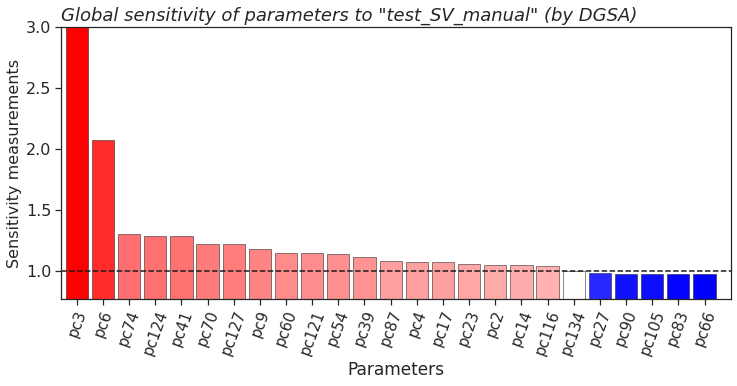

In [55]:
##########################################################################
    ##           STEP 5. GSA               ##
##########################################################################
print("  ")
print("5. Global Sensitivity anlaysis-DGSA")
m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))[:, :m_pcnum]
d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))[:, :d_pcnum]

headers = []
for para in range(m_pcnum):
    headers.append('pc' + str(para + 1))
try:
    SA_measure = DGSA_light(m_pcscr_pri, d_pcscr, headers)
except Exception as error:
    print(str(error))
gsa_pareto_plt(SA_measure, model_name)
np.save(output_data.joinpath('SA_measure_' + model_name + '.npy'), SA_measure)


  0%|          | 0/3 [00:00<?, ?it/s]

  
6. Unceratinty reduction
  
6.1 QC model and data statistical relationships


100%|██████████| 3/3 [00:32<00:00, 10.74s/it]


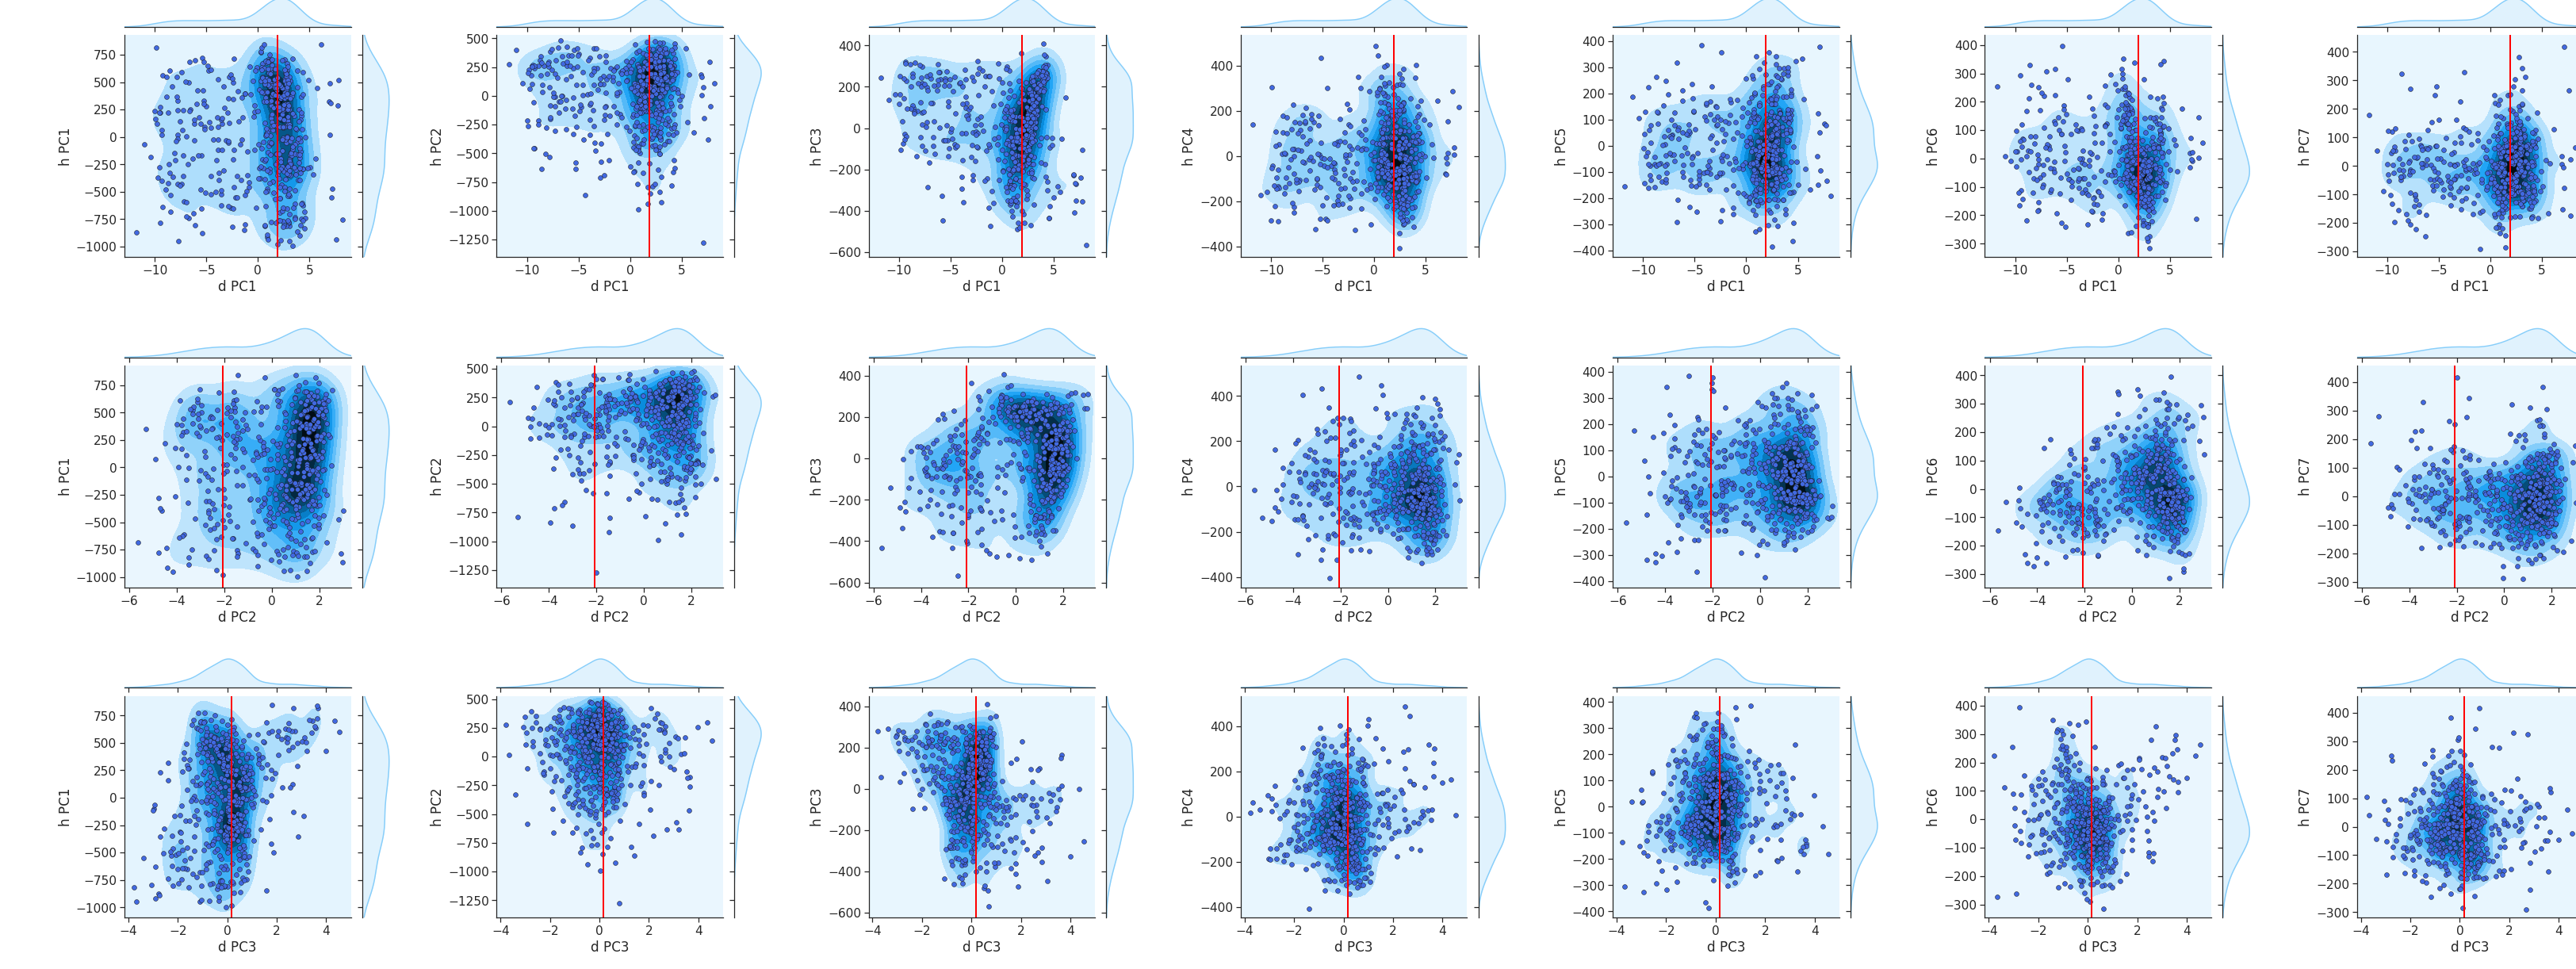

In [56]:
##########################################################################
    ##           STEP 6.  Uncertainty reduction              ##
##########################################################################
print("  ")
print("6. Unceratinty reduction")
print("  ")
##########################################################################
##          STEP 6.1     QC statistical relationships           ##
print("6.1 QC model and data statistical relationships")
SA_measure = np.load(output_data.joinpath('SA_measure_' + model_name + '.npy'))[:, 0]
sensitive_pcnum = np.argwhere(SA_measure > 1)[:len(d_pcscr[1]), 0]

m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))[:, :m_pcnum]
d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))[:, :d_pcnum]
d_pcscr_obs = np.load(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)))[:,:d_pcnum]

rgrplt_all_dh(d_pcscr_pri, m_pcscr_pri, d_pcscr_obs,
              [1, 2, 3], [1, 2, 3, 4, 5, 6, 7])

m_star = m_pcscr_pri[:, sensitive_pcnum]
d_star = d_pcscr_pri
dobs_star = d_pcscr_obs


In [78]:
d_c.shape

(494, 19)

In [83]:
m_c.shape

(494, 19)

In [81]:
cca_d_h??

In [82]:
m_star.shape

(494, 19)

  
6.2 Canonical Corrleation Analysis


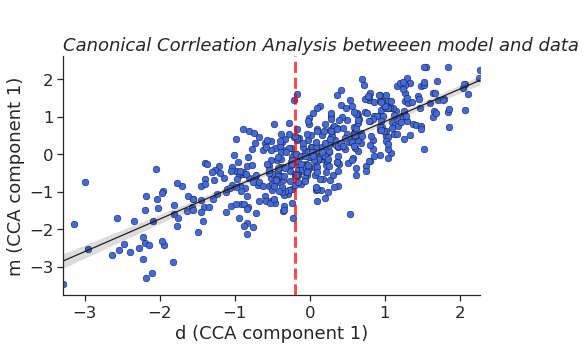

In [71]:
#######################################################################
##          STEP 6.2  CCA             ##
print("  ")
print("6.2 Canonical Corrleation Analysis")

d_c, m_c, ad, am = cca_d_h(d_star, m_star, len(m_star[0, :]))
dobs_c = np.matmul(dobs_star, ad)
d_c = np.matmul(d_star, ad)
m_c = np.matmul(m_star, am)
cca_plt(d_c, m_c, dobs_c, 1)


In [85]:
cal_c_dd_star_pca_cca??

  
6.3 Parametric Gaussian Regression & posterior sampling
  
6.4 Reconstruct posterior model


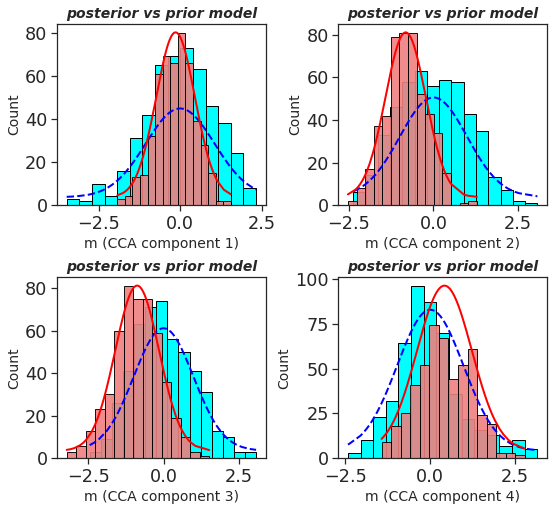

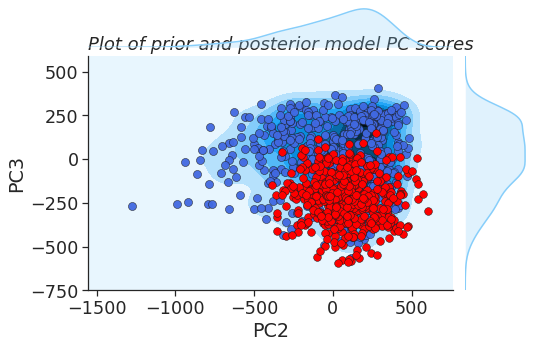

In [94]:

#######################################################################
##          STEP 6.3 Gaussian Regression                ##
print("  ")
print("6.3 Parametric Gaussian Regression & posterior sampling")

#######################################################################
##          STEP 6.4 Reconstruct posterior model                ##
err_levl = 0.00
dpca_eigenvec = np.load(output_data.joinpath('{}_dpca_eigenvec.npy'.format(model_name)))[:,:d_pcnum].T
cdd_star = cal_c_dd_star_pca_cca(dpca_eigenvec, ad, err_levl, d_obs)
post_est_clsplt([1, 2, 3, 4], m_c, d_c, dobs_c, cdd_star, 2, 2)

print("  ")
print("6.4 Reconstruct posterior model")
all_mc_post = []
for cca_comp in range(1, len(m_star[0, :]) + 1):
    all_mc_post.append(post_est_rtn_val(
        cca_comp, m_c, d_c, dobs_c, cdd_star, 0))
all_mc_post = np.asarray(all_mc_post).T
m_pcscr_post_SA = all_mc_post.dot(np.linalg.inv(am))
m_pcscr_post = np.load(output_model.joinpath(model_name + '_pcscr_pri.npy'))
m_pcscr_post[:, sensitive_pcnum] = m_pcscr_post_SA
plt_pos_pri_comp(
    sensitive_pcnum[0] + 1, sensitive_pcnum[1] + 1, m_pcscr_pri, m_pcscr_post)

m_eigvec = np.load(output_model.joinpath('{}_eigvec_pri.npy'.format(model_name)))

m_pri_mean = np.load(output_model.joinpath('{}_mean_pri.npy'.format(model_name)))

m_post = m_pcscr_post.dot(m_eigvec.T) + m_pri_mean
np.save(output_model.joinpath(model_name + '_model_post'), m_post)


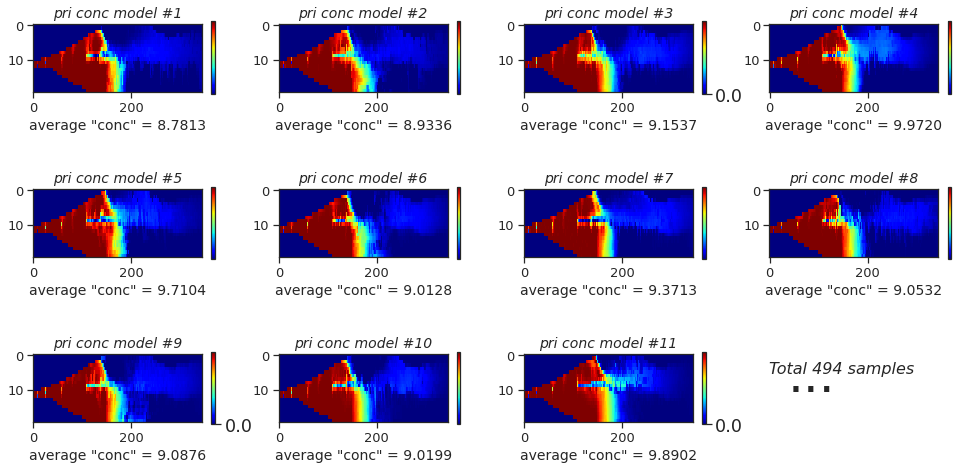

In [97]:
mc_samples_plot_2(m_post,'conc','pri',matshape_conc,10,aspect=7,cmap='jet',
                           vmin=0,vmax=35.,interpolation='nearest')


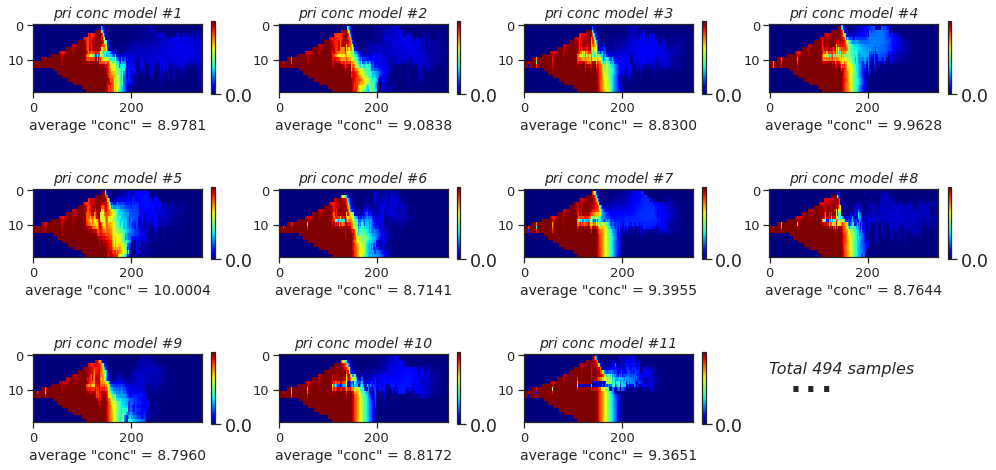

In [99]:
d_conc_plot = d_conc.copy()
d_conc_plot[d_conc==0]=0


mc_samples_plot_2(d_conc_plot,'conc','pri',matshape_conc,10,aspect=7,cmap='jet',
                           vmin=0,vmax=35.,interpolation='nearest')



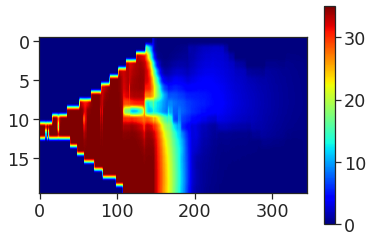

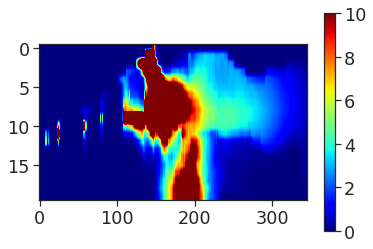

In [112]:
plt.imshow(d_conc_plot.mean(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=35)
plt.gca().set_aspect(10)
plt.colorbar()
plt.show()
plt.imshow(d_conc_plot.var(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=10)
plt.gca().set_aspect(10)
plt.colorbar()

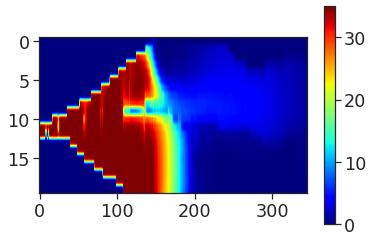

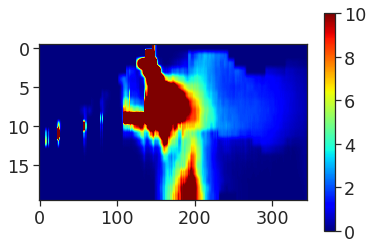

In [111]:
# m_post[m_post==0] = np.nan

plt.imshow(m_post.mean(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=35)
plt.gca().set_aspect(10)
plt.colorbar()
plt.show()
plt.imshow(m_post.var(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=10)
plt.gca().set_aspect(10)
plt.colorbar()

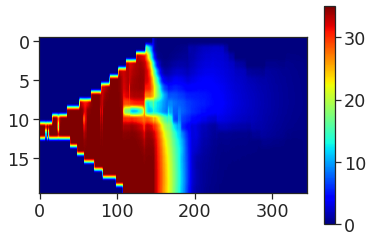

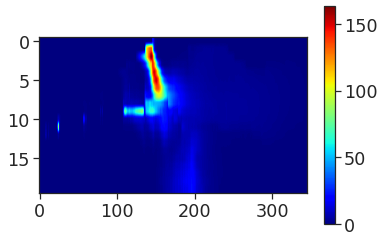

In [119]:
plt.imshow(d_conc_plot.mean(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=35)
plt.gca().set_aspect(10)
plt.colorbar()
plt.show()
plt.imshow(d_conc_plot.var(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet')
plt.gca().set_aspect(10)
plt.colorbar()

In [100]:
plt.subplots(figsize=(9,4.5))
sns.distplot(giip_a, bins=int(len(giip_a)/10), \
            kde_kws={'linewidth': 2,"color":"blue"}, \
            hist_kws={'color':'aqua',"edgecolor":'black','linewidth':0.6,'alpha':0.95})

sns.distplot(giip_b, bins=int(len(giip_b)/12.5), \
            kde_kws={'linewidth': 3,  "color":"red", }, \
            hist_kws={'color':'tomato',"edgecolor":'black','linewidth':0.6, 'alpha':0.7})
plt.ylabel('Density', fontsize = 20, fontname='calibri')
plt.xlabel('GIIP', fontsize = 20, fontname='calibri')
plt.title('Posterior and Prior predicton with "' + model_name+ '" model', fontsize=18, loc='right', style='italic')

(494, 131100)

In [96]:

def mc_samples_plot_2(model_ndarray, m_name, pri_post, matshape, layernum,aspect=1,**kwargs):
    '''
    Plot the 1st to 12th monte carlo model samples. 
    Args:
        model_ndarray: (str) the ndarray of monte carlo model samples, N_realizations x Grid_dims
        i_dim, j_dim, k_dim: x, y, z dimensions of one model realization. 
        layernum: which layer to show
        m_type: type of the model, 1 - continous; 2 - categorical
        
    Output:
        Pareto Plot for SA
    '''
    fig=plt.figure(figsize=(15,14))
    count = 1
    for realnum in range(12):
        if count  == 12:
            plot=fig.add_subplot(3, 4, count)
            plt.text(0.1, 0.48, '...', fontsize=50)
            plt.text(0.0, 0.6, 'Total ' + str(len(model_ndarray))+' samples', fontsize=16, style='italic')
            plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
            count = count + 1
        else:

            grid_data = model_ndarray[realnum].reshape(matshape)         
            plot=fig.add_subplot(3, 4, count)
            count = count+1

            prop_mean = format(np.mean(grid_data),'.4f')
            plot.set_xlabel('average "' + m_name + '" = ' + str(prop_mean), fontsize = 14)
            c_max = np.max(grid_data[layernum-1])*1.05
            c_min = np.min(grid_data[layernum-1])

            plt.imshow(grid_data[:,layernum,:],**kwargs)  
            plt.gca().set_aspect(aspect)
            plt.xticks(fontsize = 13)
            plt.yticks(fontsize = 13)
            plt.title(pri_post +' ' +m_name+ ' model #'+str(count-1), fontsize=14, style='italic')

#             plt.colorbar(fraction = 0.02)
            plt.colorbar(fraction = 0.02, ticks=np.around([c_min*1.1, c_max], decimals=1))
    plt.subplots_adjust(top=0.55, bottom=0.08, left=0.10, right=0.95, hspace=0.15,
                    wspace=0.35)
    return

In [121]:

#######################################################################
##          STEP 6.5 QC posterior results               ##

print("  ")
print("6.5. QC posterior results")
print("  ")
print("6.5.1 Plot posterior models")
m_pri = np.load(pri_m_samples_dir + model_names[i] + '.npy')
d_obs = np.c_[np.loadtxt(fname=dobs_file, skiprows=1)[:, :3], np.loadtxt(
    fname=dobs_file, skiprows=1)[:, i + 3:i + 4]]
# m_sampls_plt(m_post, samples_size, model_names[i], x_dim, y_dim, z_dim)
mc_samples_plot(m_post, model_names[i], model_types[
                i], 'Posterior', x_dim, y_dim, z_dim, 1)
m_ensampl_plt(m_post, m_pri,  model_names[
              i], 1, x_dim, y_dim, 1, d_obs)

print("  ")
print("6.5.2 Calculate posterior prediction")
GIIP_post = GIIP_cal(1, 0, m_post, grid_h_resolution, False)
np.save('output/prediction/GIIP_post', GIIP_post)
GIIP_pri = np.load('output/prediction/GIIP_pri.npy')
giip_compare(GIIP_pri, GIIP_post, model_names[i])



  
6.5. QC posterior results
  
6.5.1 Plot posterior models


NameError: name 'pri_m_samples_dir' is not defined

In [101]:
giip_compare??

In [38]:
d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))
m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))
d_pcscr_obs = np.load(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)))

In [26]:
m_pcscr_pri.shape

(494, 494)

In [23]:
np.save(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)), d_pcscr_obs)
np.save(output_data.joinpath('{}_dpca_eigenvec.npy'.format(model_name)), d_pca.components_)

np.load(output_model.joinpath('{}_mean_pri.npy'.format(model_name)))
np.load(output_model.joinpath('{}_eigvec_pri.npy'.format(model_name)))



['test']

In [66]:
from scipy.spatial.distance import pdist,squareform

In [67]:
# distmat = squareform(pdist(np.r_[d_AEM,d_obs.reshape(1,-1)],))
from scipy.spatial.distance import pdist,squareform
distmat = squareform(pdist(np.r_[d_pri,d_obs]))

In [153]:
maxind = np.argmax(distmat[-1,:-1])
its_AEM[maxind]

156

In [169]:
its_AEM[269]

280

In [168]:
np.where(distmat[-1,:-1]==np.sort(distmat[-1,:-1])[1])

(array([269]),)

In [68]:
minind = distmat[-1,:-1]
min_AEM = d_AEM[minind,:]

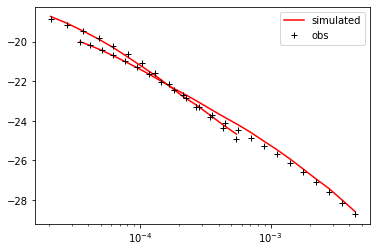

In [110]:
dHM,dLM = reshapeAEM(min_AEM)
dHMobs,dLMobs = reshapeAEM(d_obs_stash)

i_line=22
n_lines=1
plt.semilogx(times_HM_304,dHM[:,i_line:i_line+n_lines],'r',label='simulated')
plt.semilogx(times_LM_304,dLM[:,i_line:i_line+n_lines],'r')

plt.semilogx(times_HM_304,dHMobs[:,i_line:i_line+n_lines],'k+',label='obs')
plt.semilogx(times_LM_304,dLMobs[:,i_line:i_line+n_lines],'k+')
plt.legend()

In [109]:
diff_dbdt = np.abs(np.nanmin((dHM - dHMobs),axis=0))
diff_dbdt[np.isnan(diff_dbdt)]=100.
np.argmin(diff_dbdt)

22

In [112]:
its_AEM[minind]

406

In [115]:
case

'SV'

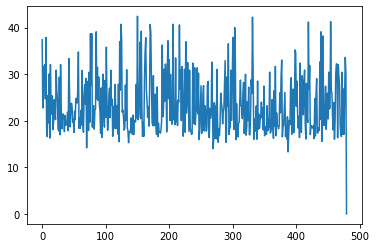

In [114]:
plt.plot(distmat[-1,:])


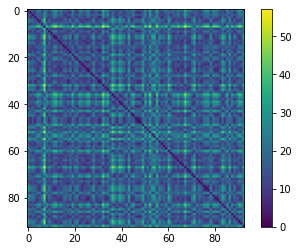

In [73]:
plt.imshow(distmat[minind:,minind:])
plt.colorbar()

(array([2.42000e+02, 7.25000e+02, 6.08800e+03, 1.49954e+05, 3.97700e+03,
        5.00000e+02, 5.50000e+01, 3.30000e+01, 1.40000e+01, 1.60000e+01]),
 array([-5.13202974e-09, -3.64171348e-09, -2.15139722e-09, -6.61080964e-10,
         8.29235295e-10,  2.31955155e-09,  3.80986781e-09,  5.30018407e-09,
         6.79050033e-09,  8.28081659e-09,  9.77113285e-09]),
 <a list of 10 Patch objects>)

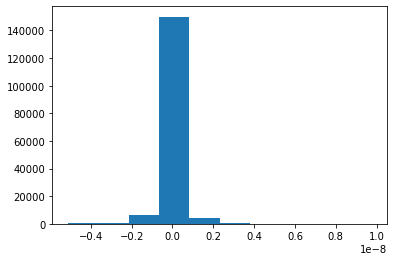

In [116]:
plt.hist((d_pri-d_obs).flatten())

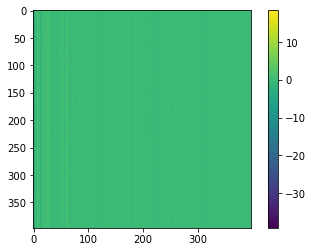

In [87]:
plt.imshow(d_pri-d_obs)
plt.colorbar()

##### Load observed data

##### Mahabonabonlis distance

In [ ]:
m_eigvec_pri.shape

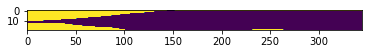

In [41]:
plt.imshow(d_conc[0].reshape(matshape_conc)[:,0,:])

### Plot

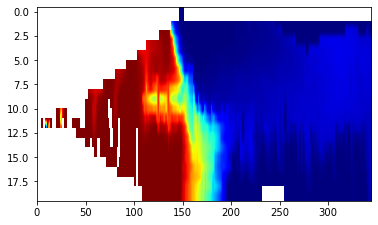

In [94]:
conc[conc>100]=np.nan

plt.imshow(conc[:,10,:],vmin=0,vmax=35.,cmap='jet')
plt.gca().set_aspect(10)

In [76]:
for f in ucn

TypeError: only integer scalar arrays can be converted to a scalar index

In [74]:
dd = {}

for 



233

In [59]:
data

In [19]:
ucnpaths = glob.glob(output_SV.joinpath('*_{}.UCN'.format(job_id)).as_posix())
f= ucnpaths[0]
f.split('_')

['/scratch/users/ianpg/SWIlarge/work/output/SV/conc75',
 '20200704',
 '1110',
 'totim14782',
 '3573022.UCN']

In [25]:
totims = np.array([int([s for s in f.split('_') if 'totim' in s][0].lstrip('totim')) for f in ucnpaths])
